In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Salaire moyen") \
    .getOrCreate()

### Extraction du fichier


In [10]:
df = spark.read.csv('files/insertion-diplomes.csv', sep=";", header=True)

### Extraction Webservices

In [11]:
import requests, pandas as pd
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
url = "https://www.data.gouv.fr/fr/datasets/r/ce8d329e-e39d-41cf-8e1b-3eb76bc69d1f"
csv = pd.read_csv(url, sep=";", on_bad_lines='error')

In [12]:
df_csv = spark.createDataFrame(csv.astype(str))

### Filtre sur Caen

In [13]:
from pyspark.sql.functions import upper

df_caen = df.filter(upper(df.academie).contains('CAEN') & upper(df.code_de_la_discipline).contains('DISC16') & ~df.salaire_net_median_des_emplois_a_temps_plein.contains("ns"))

### Graphique (évolution du salaire par an)

In [14]:
from pyspark.sql.types import IntegerType

df_caen = df_caen.withColumnRenamed('salaire_net_median_des_emplois_a_temps_plein', 'salaire_moyen')

df_caen = df_caen.withColumn("annee", df_caen['annee'].cast(IntegerType()))
df_caen = df_caen.withColumn('salaire_moyen', df_caen['salaire_moyen'].cast('integer'))

In [15]:
df_caen = df_caen.sort(df.annee.asc())
df_hist = df_caen.select(['annee', 'salaire_moyen']).toPandas()

<AxesSubplot:xlabel='annee'>

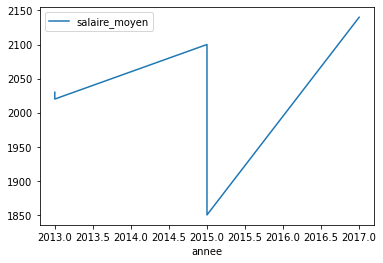

In [16]:
df_hist.plot.line(x='annee', y="salaire_moyen")